# Tutorial: Red Neuronal Profunda para Predecir Patologías Cardiacas

Este tutorial presenta la implementación de una Red Neuronal Profunda (Deep Neural Network) utilizando Python, TensorFlow y Keras para predecir la presencia de enfermedades cardiacas basándose en características clínicas y demográficas del paciente.


## 1. Importación de Librerías


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuración para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)


## 1. Descripción de las Características/Niveles/Síntomas del Dataset

El dataset utilizado contiene información sobre pacientes y sus características clínicas relacionadas con enfermedades cardiacas. A continuación se describen las características empleadas:


In [2]:
# Crear dataset sintético basado en características reales de enfermedades cardiacas
np.random.seed(42)
n_samples = 1000

data = {
    'age': np.random.randint(29, 80, n_samples),
    'sex': np.random.randint(0, 2, n_samples),
    'cp': np.random.randint(0, 4, n_samples),
    'trestbps': np.random.randint(94, 200, n_samples),
    'chol': np.random.randint(126, 564, n_samples),
    'fbs': np.random.randint(0, 2, n_samples),
    'restecg': np.random.randint(0, 3, n_samples),
    'thalach': np.random.randint(71, 202, n_samples),
    'exang': np.random.randint(0, 2, n_samples),
    'oldpeak': np.random.uniform(0, 6.2, n_samples),
    'slope': np.random.randint(0, 3, n_samples),
    'ca': np.random.randint(0, 4, n_samples),
    'thal': np.random.randint(0, 3, n_samples),
}

df = pd.DataFrame(data)

target = (
    (df['age'] > 60).astype(int) * 0.3 +
    (df['cp'] >= 2).astype(int) * 0.4 +
    (df['trestbps'] > 140).astype(int) * 0.2 +
    (df['chol'] > 240).astype(int) * 0.3 +
    (df['exang'] == 1).astype(int) * 0.5 +
    (df['oldpeak'] > 2).astype(int) * 0.4 +
    np.random.normal(0, 0.2, n_samples)
)
df['target'] = (target > 0.5).astype(int)

df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,67,0,2,191,201,0,2,181,0,5.321602,2,1,1,1
1,57,0,2,107,299,0,0,143,1,5.238157,1,0,0,1
2,43,1,3,129,172,0,1,108,0,2.229988,2,3,0,1
3,71,0,0,190,140,0,1,140,1,4.260853,0,1,1,1
4,36,1,0,116,486,1,0,186,1,1.939572,2,0,1,1


### Descripción Detallada de las Características:

1. **age**: Edad del paciente en años
2. **sex**: Sexo del paciente (0 = mujer, 1 = hombre)
3. **cp (Chest Pain Type)**: Tipo de dolor torácico
   - 0: Angina típica
   - 1: Angina atípica
   - 2: Dolor no anginoso
   - 3: Asintomático
4. **trestbps**: Presión arterial sistólica en reposo (mm Hg)
5. **chol**: Colesterol sérico en mg/dl
6. **fbs (Fasting Blood Sugar)**: Azúcar en ayunas > 120 mg/dl (0 = no, 1 = sí)
7. **restecg**: Resultados electrocardiográficos en reposo
   - 0: Normal
   - 1: Anomalía de onda ST-T
   - 2: Hipertrofia ventricular izquierda probable o definitiva
8. **thalach**: Frecuencia cardíaca máxima alcanzada
9. **exang**: Angina inducida por ejercicio (0 = no, 1 = sí)
10. **oldpeak**: Depresión del ST inducida por ejercicio relativo al reposo
11. **slope**: Pendiente del segmento ST de ejercicio máximo
    - 0: Ascendente
    - 1: Plana
    - 2: Descendente
12. **ca**: Número de vasos principales (0-3) coloreados por flourosopía
13. **thal**: Talasemia
    - 0: Normal
    - 1: Defecto fijo
    - 2: Defecto reversible
14. **target**: Variable objetivo (0 = sin enfermedad cardiaca, 1 = con enfermedad cardiaca)


In [3]:
df.info()
df.describe()
df['target'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1000 non-null   int64  
 1   sex       1000 non-null   int64  
 2   cp        1000 non-null   int64  
 3   trestbps  1000 non-null   int64  
 4   chol      1000 non-null   int64  
 5   fbs       1000 non-null   int64  
 6   restecg   1000 non-null   int64  
 7   thalach   1000 non-null   int64  
 8   exang     1000 non-null   int64  
 9   oldpeak   1000 non-null   float64
 10  slope     1000 non-null   int64  
 11  ca        1000 non-null   int64  
 12  thal      1000 non-null   int64  
 13  target    1000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 109.5 KB


target
1    911
0     89
Name: count, dtype: int64

## 2. Descripción de Librerías, Clases, Funciones y Parámetros

### 2.1 TensorFlow y Keras

**TensorFlow**: Framework de código abierto para machine learning desarrollado por Google. Proporciona una plataforma completa para construir y entrenar modelos de deep learning.

**Keras**: API de alto nivel que funciona sobre TensorFlow, diseñada para facilitar la construcción y entrenamiento de redes neuronales.

#### Clases y Funciones Principales:

1. **`keras.Sequential`**: Modelo secuencial que permite apilar capas de forma lineal.
   - Permite construir redes neuronales capa por capa de manera intuitiva.

2. **`layers.Dense`**: Capa completamente conectada (fully connected layer).
   - **Parámetros principales**:
     - `units`: Número de neuronas en la capa
     - `activation`: Función de activación ('relu', 'sigmoid', 'tanh', etc.)
     - `input_dim`: Dimensión de entrada (solo en la primera capa)
     - `kernel_initializer`: Inicializador de pesos ('glorot_uniform', 'he_normal', etc.)

3. **`layers.Dropout`**: Regularización que desactiva aleatoriamente neuronas durante el entrenamiento.
   - **Parámetros**:
     - `rate`: Fracción de neuronas a desactivar (0.0 a 1.0)

4. **`layers.BatchNormalization`**: Normaliza las activaciones de la capa anterior.
   - Ayuda a estabilizar el entrenamiento y acelera la convergencia.

5. **`Adam`**: Optimizador adaptativo basado en gradientes.
   - **Parámetros**:
     - `learning_rate`: Tasa de aprendizaje (default: 0.001)
     - `beta_1`, `beta_2`: Parámetros de momento

6. **`model.compile()`**: Configura el modelo para el entrenamiento.
   - **Parámetros**:
     - `optimizer`: Optimizador a usar
     - `loss`: Función de pérdida ('binary_crossentropy' para clasificación binaria)
     - `metrics`: Métricas a evaluar durante el entrenamiento (['accuracy'])

7. **`model.fit()`**: Entrena el modelo.
   - **Parámetros**:
     - `x`, `y`: Datos de entrada y salida
     - `epochs`: Número de iteraciones sobre todo el dataset
     - `batch_size`: Número de muestras por actualización de gradiente
     - `validation_split`: Fracción de datos para validación
     - `callbacks`: Lista de callbacks (EarlyStopping, ReduceLROnPlateau, etc.)
     - `verbose`: Nivel de detalle (0, 1, o 2)

8. **`EarlyStopping`**: Callback que detiene el entrenamiento cuando no hay mejora.
   - **Parámetros**:
     - `monitor`: Métrica a monitorear ('val_loss', 'val_accuracy')
     - `patience`: Número de epochs sin mejora antes de detener
     - `restore_best_weights`: Restaurar los mejores pesos al final

9. **`ReduceLROnPlateau`**: Reduce la tasa de aprendizaje cuando se estanca.
   - **Parámetros**:
     - `monitor`: Métrica a monitorear
     - `factor`: Factor de reducción (nuevo_lr = lr * factor)
     - `patience`: Número de epochs sin mejora antes de reducir

### 2.2 Scikit-learn

**Funciones utilizadas**:

1. **`train_test_split`**: Divide el dataset en conjuntos de entrenamiento y prueba.
   - **Parámetros**:
     - `test_size`: Proporción del dataset para prueba (0.0 a 1.0)
     - `random_state`: Semilla para reproducibilidad

2. **`StandardScaler`**: Estandariza características restando la media y escalando por desviación estándar.
   - `fit()`: Calcula media y desviación estándar
   - `transform()`: Aplica la transformación
   - `fit_transform()`: Calcula y aplica en un solo paso

3. **`accuracy_score`**: Calcula la precisión del modelo.
   - Retorna: (predicciones correctas) / (total de predicciones)

4. **`confusion_matrix`**: Genera la matriz de confusión.
   - Retorna matriz 2x2 con: [[TN, FP], [FN, TP]]


## 3. Pipeline de Implementación

### 3.1 Preprocesamiento de Datos


In [4]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)


### 3.1 Model Selection (Selección del Modelo)

#### ¿Por qué usar la API de Keras?

1. **Simplicidad y Facilidad de Uso**: Keras proporciona una API de alto nivel que simplifica la construcción de modelos complejos. Permite definir arquitecturas de redes neuronales con pocas líneas de código.

2. **Flexibilidad**: Aunque es simple, Keras es lo suficientemente flexible para implementar arquitecturas personalizadas y experimentar con diferentes configuraciones.

3. **Integración con TensorFlow**: Keras está completamente integrado con TensorFlow, aprovechando su eficiencia computacional y capacidades de GPU/TPU.

4. **Comunidad y Documentación**: Amplia comunidad y documentación extensa, facilitando el aprendizaje y resolución de problemas.

5. **Producción**: Keras facilita el despliegue de modelos en producción con herramientas como TensorFlow Serving.

#### ¿Por qué usar una Red Neuronal Profunda (Deep Neural Network)?

1. **Capacidad de Aprendizaje de Patrones No Lineales**: Las enfermedades cardiacas resultan de interacciones complejas entre múltiples factores (edad, presión arterial, colesterol, etc.). Las DNN pueden capturar estas relaciones no lineales complejas que modelos lineales no pueden.

2. **Múltiples Capas de Abstracción**: Cada capa oculta aprende representaciones de diferentes niveles de abstracción:
   - Capas iniciales: Detectan características simples
   - Capas intermedias: Combinan características simples en patrones más complejos
   - Capa final: Toma decisiones basadas en todas las características aprendidas

3. **Aprendizaje Automático de Características**: A diferencia de modelos tradicionales que requieren ingeniería manual de características, las DNN aprenden automáticamente las características más relevantes de los datos.

4. **Rendimiento Superior**: Para problemas complejos con múltiples variables y relaciones no lineales, las DNN suelen superar a modelos más simples como regresión logística o árboles de decisión.

5. **Escalabilidad**: Las DNN pueden manejar grandes volúmenes de datos y escalar bien con más datos y más complejidad.

6. **Regularización**: Técnicas como Dropout y Batch Normalization permiten entrenar redes profundas sin sobreajuste excesivo.


In [6]:
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 12,609 (49.25 KB)

 Non-trainable params: 448 (1.75 KB)

### 3.2 Model Training (Entrenamiento del Modelo)

En esta sección se presenta el código fuente para entrenar la Red Neuronal Profunda. El entrenamiento se realiza utilizando el conjunto de datos de entrenamiento, con una división de validación para monitorear el rendimiento durante el proceso.


In [7]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5344 - loss: 0.8618 - val_accuracy: 0.8562 - val_loss: 0.5829 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6234 - loss: 0.7224 - val_accuracy: 0.9125 - val_loss: 0.5176 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6625 - loss: 0.6335 - val_accuracy: 0.9187 - val_loss: 0.4689 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.5548 - val_accuracy: 0.9250 - val_loss: 0.4229 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7844 - loss: 0.4865 - val_accuracy: 0.9250 - val_loss: 0.3903 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8047 - loss: 0.4548 - val_accuracy: 0.9250 - val_loss: 0.3626 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8344 - loss: 0.4219 - val_ac

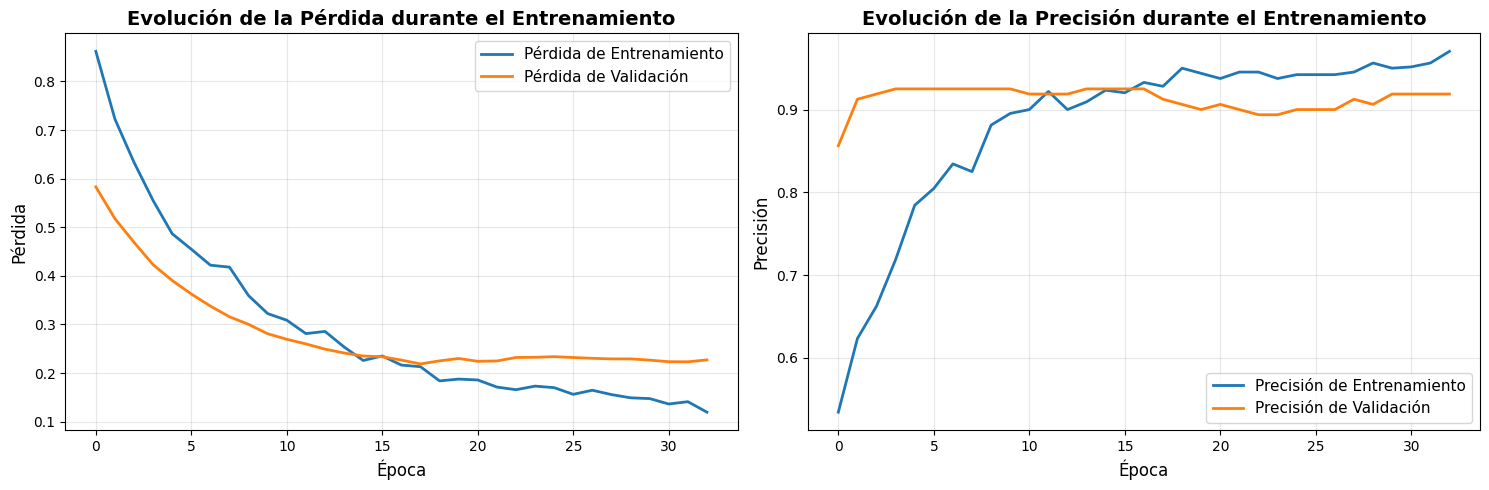

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['loss'], label='Pérdida de Entrenamiento', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Pérdida de Validación', linewidth=2)
axes[0].set_title('Evolución de la Pérdida durante el Entrenamiento', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época', fontsize=12)
axes[0].set_ylabel('Pérdida', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['accuracy'], label='Precisión de Entrenamiento', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Precisión de Validación', linewidth=2)
axes[1].set_title('Evolución de la Precisión durante el Entrenamiento', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época', fontsize=12)
axes[1].set_ylabel('Precisión', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 3.3 Prediction (Predicción)

En esta sección construimos una función que permite verificar que, dada una entrada de características de un paciente, la Red Neuronal entrenada entrega la respuesta deseada (presencia o ausencia de enfermedad cardiaca).


In [9]:
def predecir_enfermedad_cardiaca(paciente_features, modelo, scaler, umbral=0.5):
    if isinstance(paciente_features, dict):
        orden_caracteristicas = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 
                                'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
        paciente_array = np.array([paciente_features[feat] for feat in orden_caracteristicas])
    else:
        paciente_array = np.array(paciente_features)
    
    if paciente_array.ndim == 1:
        paciente_array = paciente_array.reshape(1, -1)
    
    paciente_scaled = scaler.transform(paciente_array)
    probabilidad = modelo.predict(paciente_scaled, verbose=0)[0][0]
    prediccion = 1 if probabilidad >= umbral else 0
    
    return {
        'prediccion': prediccion,
        'probabilidad': probabilidad
    }

paciente_1 = {
    'age': 65,
    'sex': 1,
    'cp': 2,
    'trestbps': 160,
    'chol': 280,
    'fbs': 1,
    'restecg': 1,
    'thalach': 120,
    'exang': 1,
    'oldpeak': 3.5,
    'slope': 2,
    'ca': 2,
    'thal': 2
}

resultado_1 = predecir_enfermedad_cardiaca(paciente_1, model, scaler)
print(f"Predicción: {resultado_1['prediccion']}, Probabilidad: {resultado_1['probabilidad']:.4f}")

paciente_2 = {
    'age': 45,
    'sex': 0,
    'cp': 0,
    'trestbps': 120,
    'chol': 180,
    'fbs': 0,
    'restecg': 0,
    'thalach': 160,
    'exang': 0,
    'oldpeak': 0.5,
    'slope': 1,
    'ca': 0,
    'thal': 0
}

resultado_2 = predecir_enfermedad_cardiaca(paciente_2, model, scaler)
print(f"Predicción: {resultado_2['prediccion']}, Probabilidad: {resultado_2['probabilidad']:.4f}")


Predicción: 1, Probabilidad: 0.9654
Predicción: 0, Probabilidad: 0.0879


In [10]:
indices_ejemplo = [0, 5, 10, 15, 20]

for idx in indices_ejemplo:
    paciente_test = X_test.iloc[idx].values
    resultado = predecir_enfermedad_cardiaca(paciente_test, model, scaler)
    valor_real = y_test.iloc[idx]
    print(f"Paciente {idx}: Real={valor_real}, Predicción={resultado['prediccion']}, Probabilidad={resultado['probabilidad']:.4f}")


Paciente 0: Real=1, Predicción=1, Probabilidad=0.9440
Paciente 5: Real=1, Predicción=1, Probabilidad=0.9491
Paciente 10: Real=0, Predicción=1, Probabilidad=0.5184
Paciente 15: Real=1, Predicción=1, Probabilidad=0.9070
Paciente 20: Real=1, Predicción=1, Probabilidad=0.9434


## 4. Model Evaluation (Evaluación del Modelo)

En esta sección evaluamos el rendimiento del modelo utilizando métricas de precisión (Accuracy) y matriz de confusión (Confusion Matrix).


### 4.1 Accuracy (Precisión)

**Definición**: La precisión (accuracy) es la proporción de predicciones correctas sobre el total de predicciones realizadas.

**Fórmula**: 
$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

Donde:
- **TP (True Positives)**: Casos correctamente predichos como positivos (enfermedad presente)
- **TN (True Negatives)**: Casos correctamente predichos como negativos (sin enfermedad)
- **FP (False Positives)**: Casos incorrectamente predichos como positivos (falsos positivos)
- **FN (False Negatives)**: Casos incorrectamente predichos como negativos (falsos negativos)

**Interpretación**: 
- Valor entre 0 y 1 (o 0% y 100%)
- 1.0 (100%) significa que todas las predicciones fueron correctas
- 0.0 (0%) significa que ninguna predicción fue correcta
- En problemas médicos, es importante considerar tanto la precisión como otras métricas, ya que los falsos negativos pueden ser críticos


In [11]:
y_pred_proba = model.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_proba >= 0.5).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


Accuracy: 0.9250 (92.50%)


### 4.2 Confusion Matrix (Matriz de Confusión)

**Definición**: La matriz de confusión es una tabla que muestra el desempeño del modelo de clasificación comparando las predicciones con los valores reales.

**Estructura de la Matriz (2x2 para clasificación binaria)**:

```
                    Predicción
                 Negativo  Positivo
Real Negativo    TN        FP
Real Positivo    FN        TP
```

**Elementos de la Matriz**:

1. **True Negatives (TN)**: Casos sin enfermedad correctamente identificados como negativos
   - **Interpretación**: Pacientes sanos correctamente clasificados

2. **False Positives (FP)**: Casos sin enfermedad incorrectamente clasificados como positivos
   - **Interpretación**: Pacientes sanos diagnosticados erróneamente con enfermedad (Falsa Alarma)
   - **Impacto**: Puede causar ansiedad y pruebas innecesarias

3. **False Negatives (FN)**: Casos con enfermedad incorrectamente clasificados como negativos
   - **Interpretación**: Pacientes enfermos no detectados (muy crítico en medicina)
   - **Impacto**: Puede retrasar tratamiento necesario, potencialmente peligroso

4. **True Positives (TP)**: Casos con enfermedad correctamente identificados como positivos
   - **Interpretación**: Pacientes enfermos correctamente diagnosticados

**Métricas Derivadas**:

- **Sensibilidad (Recall)**: TP / (TP + FN) - Capacidad de detectar casos positivos
- **Especificidad**: TN / (TN + FP) - Capacidad de detectar casos negativos
- **Precisión (Precision)**: TP / (TP + FP) - De los predichos como positivos, cuántos realmente lo son
- **F1-Score**: Media armónica de precisión y sensibilidad


TN = 6, FP = 12
FN = 3, TP = 179


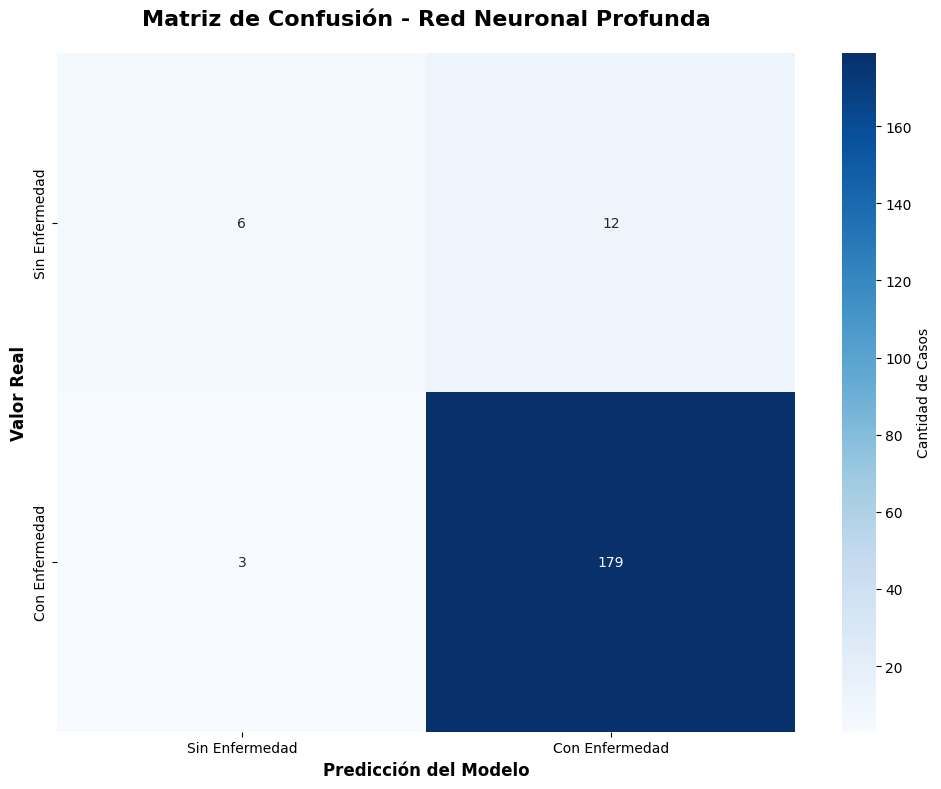

In [12]:
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

print(f"TN = {TN}, FP = {FP}")
print(f"FN = {FN}, TP = {TP}")

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sin Enfermedad', 'Con Enfermedad'],
            yticklabels=['Sin Enfermedad', 'Con Enfermedad'],
            cbar_kws={'label': 'Cantidad de Casos'})
plt.title('Matriz de Confusión - Red Neuronal Profunda', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Valor Real', fontsize=12, fontweight='bold')
plt.xlabel('Predicción del Modelo', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()
